In [ ]:
# Classiq installation and authetication
!pip install -U classiq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.6/151.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.9/387.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3

In [ ]:
import classiq
classiq.authenticate()

Your user code: ZZQT-BZRZ
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=ZZQT-BZRZ


In [22]:
# Importing needed libraries and modules
from classiq import *
import numpy as np
import random
from IPython.display import Image

In [14]:
size = 4 # log_2(16) As we need 16 nodes in a line, it can be encoded using 4qbits.
n = 2**size # number of nodes = 16



Consider a graph (line) with total 16 nodes or vertices denoted as V and edges with only the adjacent one E.

To simulate a quantum walk on a general graph, the state $|j,k⟩$ needs to be acted upon by $SC$ operators. The C operator is,
$C = \sum_{j \in V} |j⟩⟨j| \otimes \left( 2 |∂_j⟩ ⟨∂_j| - I\right) $
with $|∂_j⟩ = \frac{1}{deg(j)} \sum_{k :(j,k)\in E} |k⟩$,
where deg(j) = number of adjacent vertices to the vertex $j$. So, in our setting, except for the end vertices (0,15), all vertices have deg(j) =1/2.

For the implementation of C operator, phase kickback it used, notice
$2 |∂_j⟩ ⟨∂_j| - I = U_j \left(2 |0⟩⟨0| - I \right)U_j^{†}.$
Here $P = 2 |0⟩⟨0| - I $ when acts on any state it behaves as a phase kickback operator,
$\left(2 |0⟩⟨0| - I\right) |x⟩ = (-1)^{x \neq 0} |x⟩$.
The below code implements the needed phase kickback operator $P$.




In [15]:
# Phase Kickback Step
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

As per the explanation above, C or W_operator is implemented here.

The C operator is,
$C = \sum_{j \in V} |j⟩⟨j| \otimes \left( 2 |∂_j⟩ ⟨∂_j| - I\right) $
with $|∂_j⟩ = \frac{1}{deg(j)} \sum_{k :(j,k)\in E} |k⟩$,
where deg(j) = number of adjacent vertices to the vertex $j$. So, in our setting, except for the end vertices (0,15), all vertices have deg(j) =1/2.


Here, $U_j P U_j^{†}$ is implemented, where $prob$ is used to capture the effect of operator U as $U|0⟩$, throguh inplace_prepare_state.

And within_apply this $U_j P U_j^{†}$ is finally captured.

In [16]:

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    n = 2**size
    prob = [0]*n
    if i==0:
      prob[i+1]=1 # node == 0, its adjacent node is 1 with probability 1.
    elif i== n-1:
      prob[i-1]=1 # node == 15, its adjacent node is 14 with probability 1.
    else:
      prob[(i+1)]=0.5 #Probablity of adjacent node j+1 is 1/2 (next node)
      prob[(i-1)]=0.5 #Probablity of adjacent node j-1 is 1/2 (previous node)
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))


@qfunc
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)

Now the operator S is just bitwise swap. But requires the details of the edges of the graph. Note that this graph is a simple path or line. So the edge exists if $j-k =1 $ or $j-k =-1$, this is captured in res, in the edge_oracle.

The S operator has the form,
$S = \sum_{(j,k)\in E} |j,k⟩\langle k,j| $.

In [17]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= ((vertices-adjacent_vertices ==1) | (vertices-adjacent_vertices ==-1))


@qfunc
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))


@qfunc
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))



Here, in the main qfunc, vertices and adjacent_vertices are initailised, followed by other steps to implement H on vertices and then W and S operators

In [18]:
@qfunc
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)

# write models to files

write_qmod(qmod, "Quantum_walk_on_a_circle.qmod")


qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

Here is the full circuit of the above Quantum Random Walk on a line of 16 nodes.

Details of the circuit :
* Depth: 2992
* Width: 37

Gate count

* U : 2771
* CX : 2643

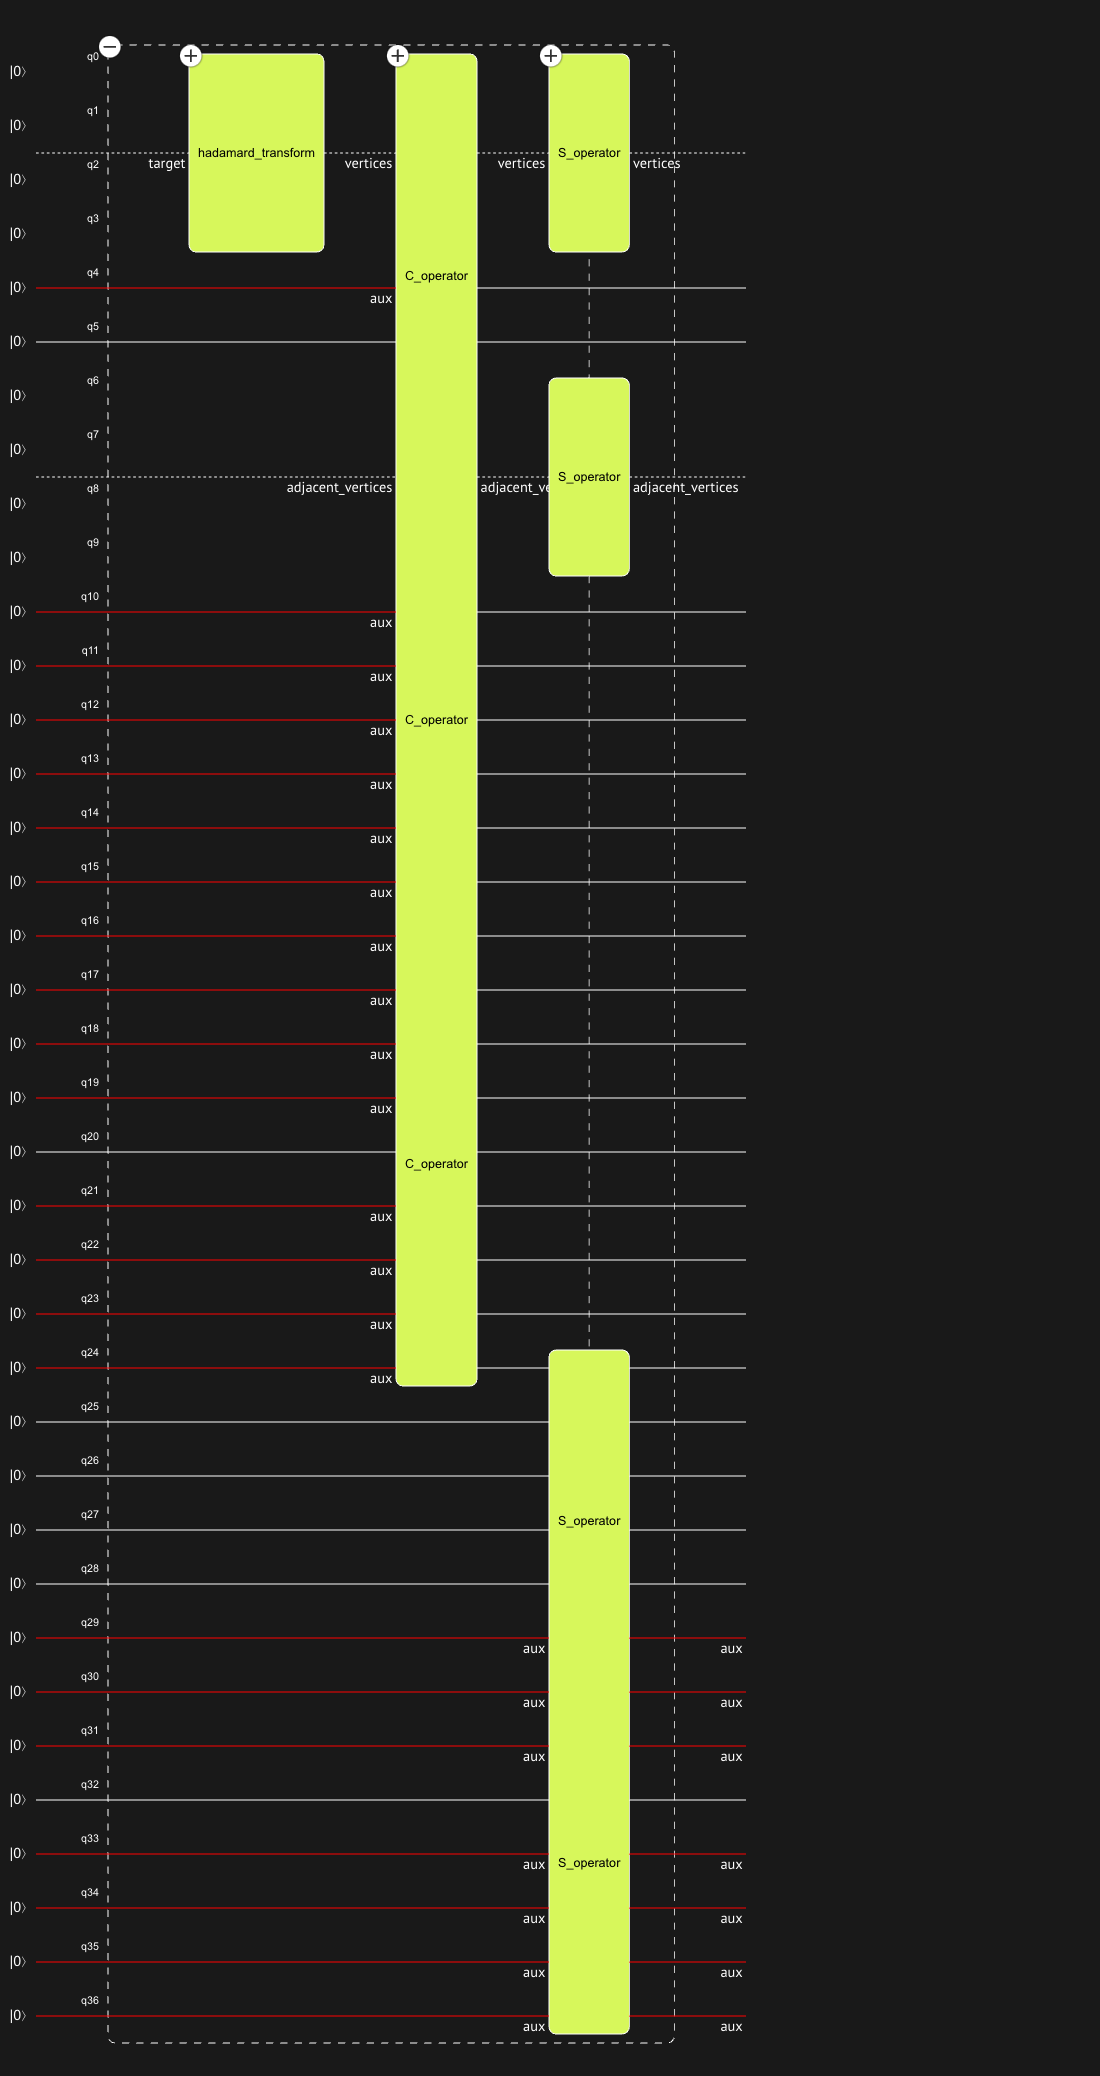

In [23]:
Image('/content/QCircuit.jpg')

Here is the C_operator. Note it is n ot possible to show all width of the circuit. For each of the 16 vertices, statePreparation followed by zero_diffuser_0 and then inverse of statePreparation is applied.

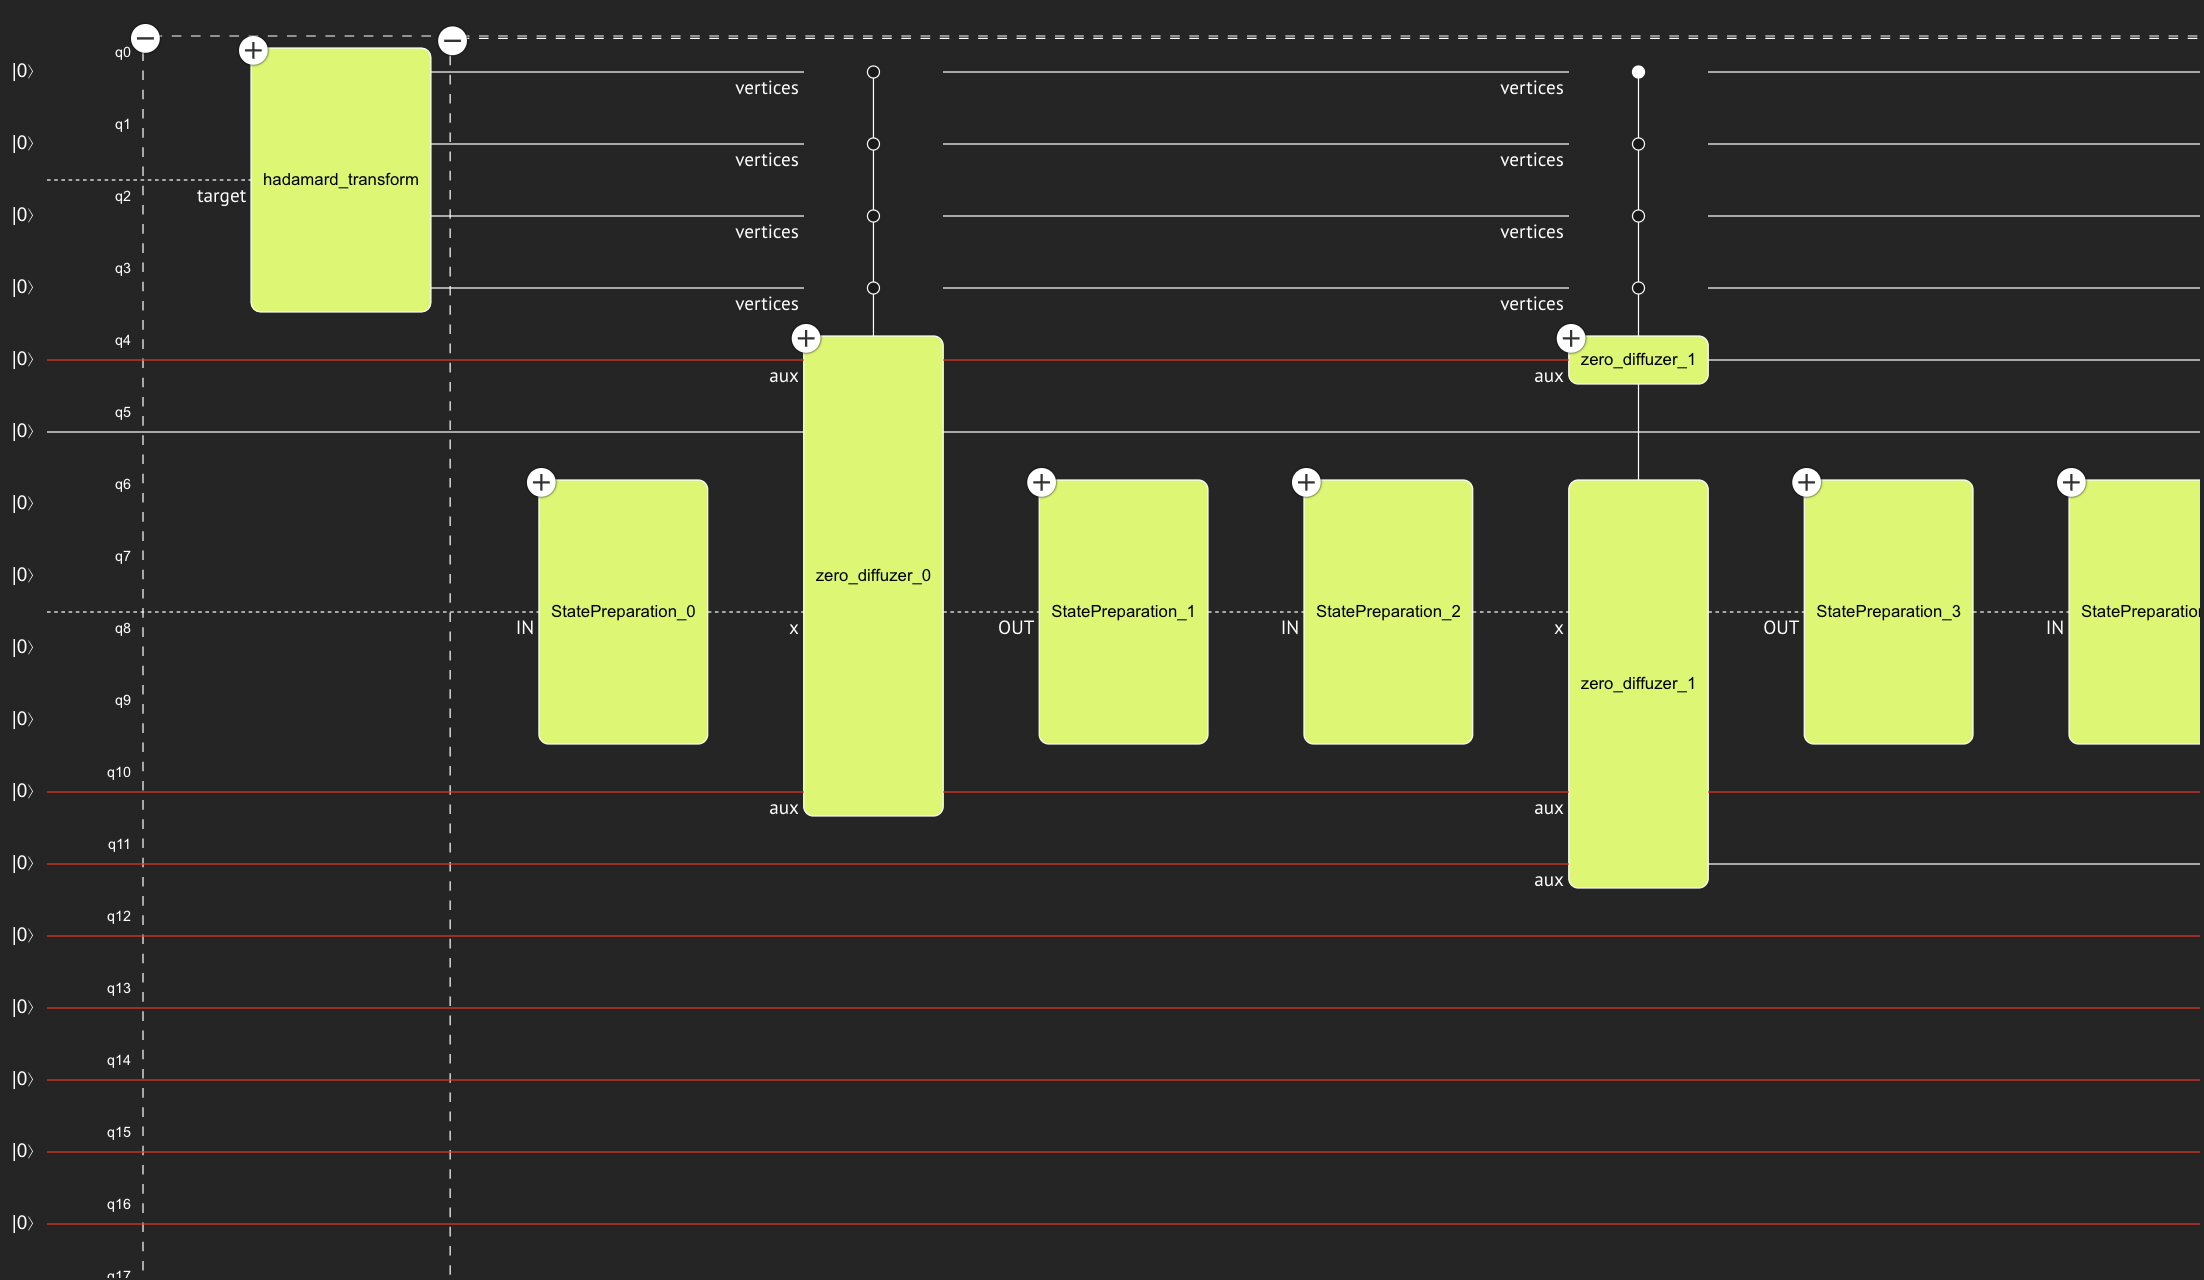

In [21]:
Image('/content/C_op.png')

Finally,v the circuit for S_op is shown below.

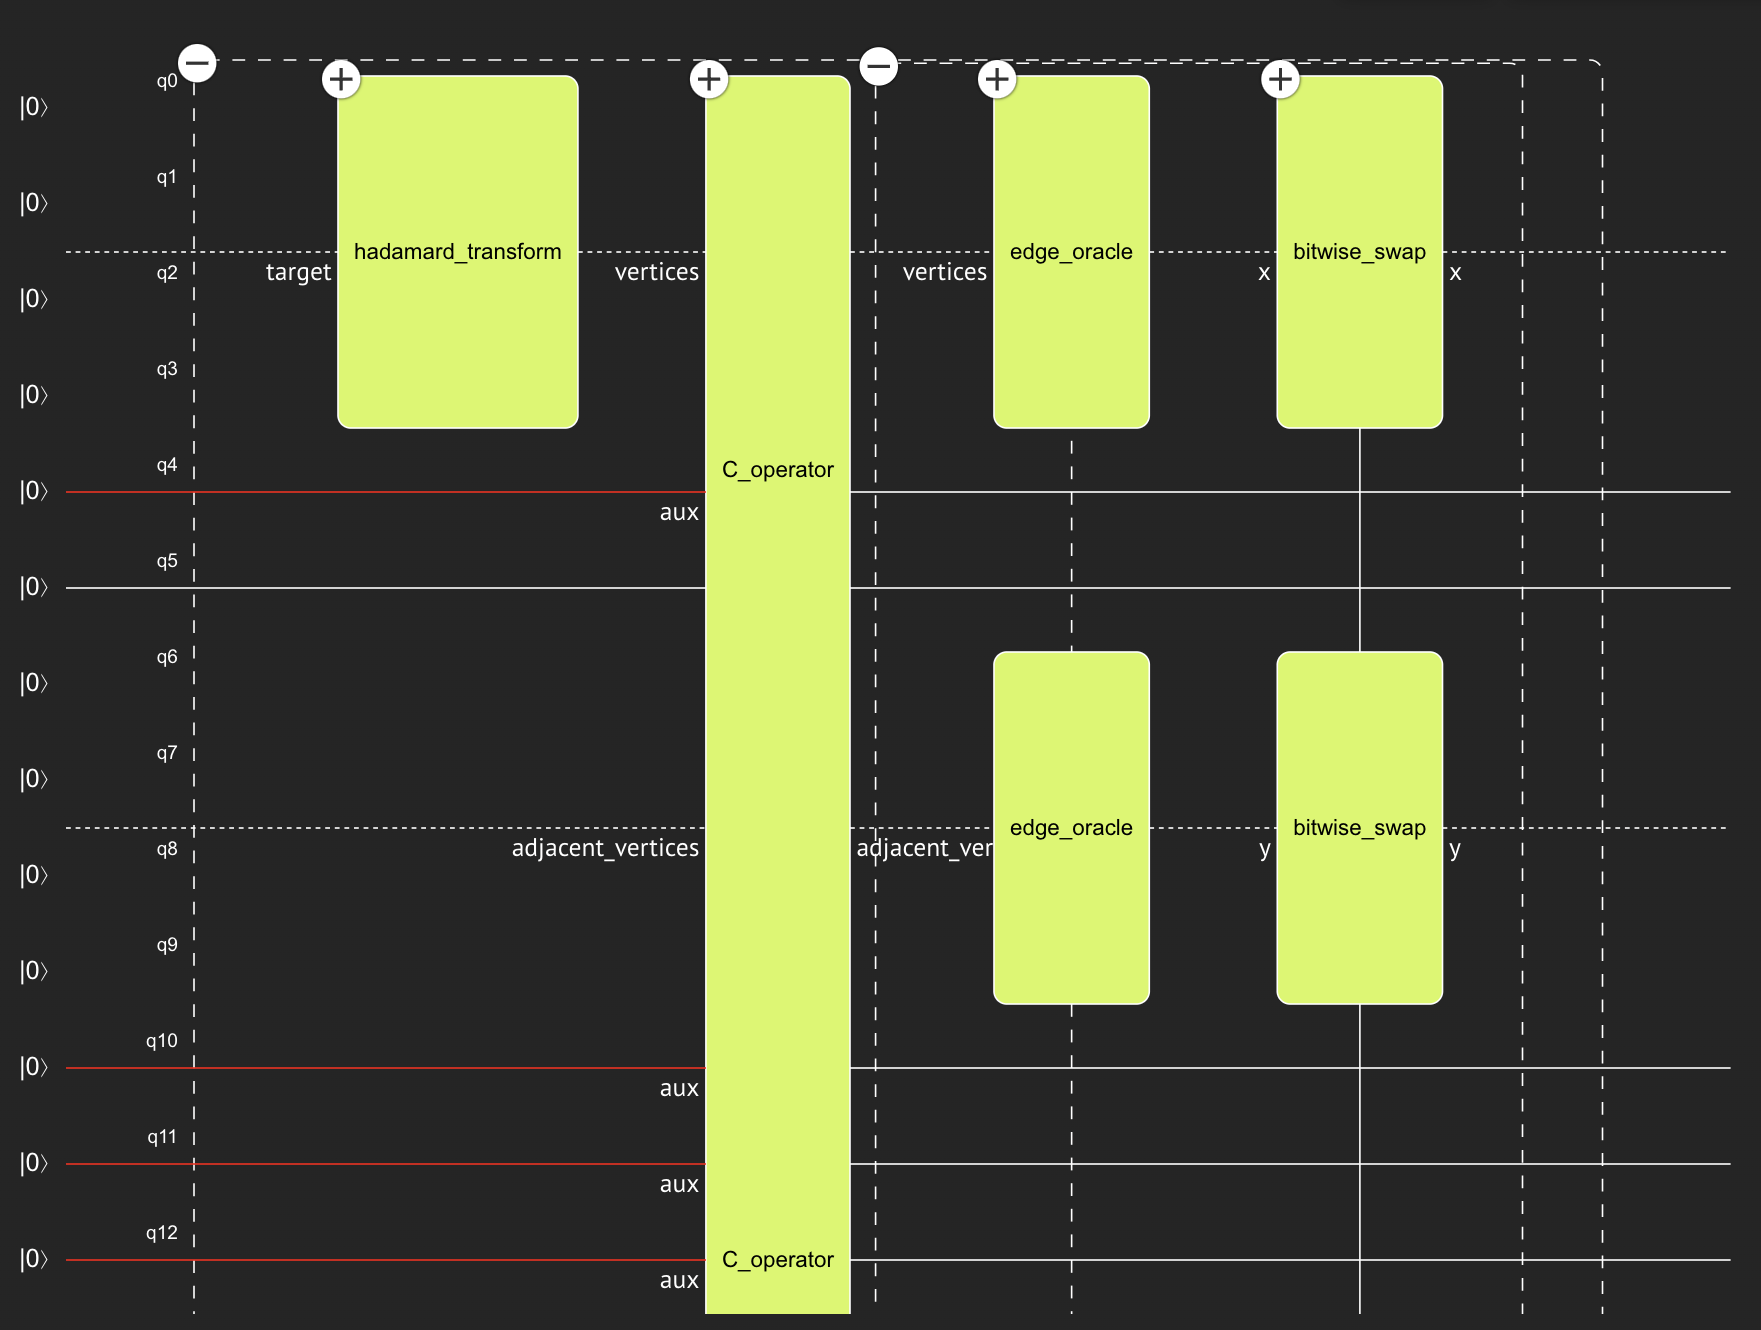

In [24]:
Image('/content/S_op.png')